# MLP
MLP, K=5, droput, 150 epoch.

lncRNA. Exclude test middle.

In [1]:

from datetime import datetime
print(datetime.now())

2023-04-09 13:38:05.446563


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
    MODEL_DIR = '/Users/jasonmiller/WVU/Localization/Models/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
#from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
#from keras.losses import Hinge

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=150 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
# MAXLEN=5000
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = True
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = True
REPEATS = 2
FOLDS = 5

SAVE_MODEL_FILENAME = None # 'MLP_245'

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None #'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None #'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        #NREPEAT = str('N'*MAXLEN)   # not used for MLP
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        # no MAXLEN for MLP
                        #if seq_len<=MAXLEN:
                        #    seq_txt = seq_txt + NREPEAT
                        #seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(128, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    drop2  = Dropout(.2)
    layer3 = Dense(64, activation='sigmoid')
    drop3  = Dropout(.2)
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(drop2)
    mlp.add(layer3)
    mlp.add(drop3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-09 13:38:40.690813
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131328    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 143,809
Trainab

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = -1 # or zero
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            filepath = MODEL_DIR + filename
            self.model.save(filepath)
            print('Saved model to',filepath)
        
    def load_model(self,filename):
        filepath = MODEL_DIR + filename
        self.model = keras.models.load_model(filepath)
        print('Loaded model from',filepath)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        #cw = class_weight.compute_class_weight('balanced', classes=[0,1], y=y_train)
        #cwd = {0: cw[0], 1: cw[1]}
        #print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            )  # no validation # class_weight=cwd)
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            validation_data=(X_valid,y_valid) ) # class_weight=cwd, 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)

        correct_pos = 0
        correct_neg = 0
        wrong_pos = 0
        wrong_neg = 0
        for i in range(len(y_test)):
            if yhat_pred[i]>=0.65:
                if y_test[i]==1:
                    correct_pos += 1
                else:
                    wrong_pos += 1
            elif yhat_pred[i]<=0.35:
                if y_test[i]==0:
                    correct_neg += 1
                else:
                    wrong_neg += 1
        print('Extreme scores correct, pos:neg',correct_pos,correct_neg)  
        print('Extreme scores incorrect pos:neg',wrong_pos,wrong_neg)  

        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        print('Opening file',filename)
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_TEST and (\
                    (FILTER_TAILS_TEST and in_tails) or \
                    (FILTER_MIDDLE_TEST and in_middle)):
                    pass
                else:
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_TRAIN and (\
                    (FILTER_TAILS_TRAIN and in_tails) or \
                    (FILTER_MIDDLE_TRAIN and in_middle)):
                    pass
                else:
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-09 13:38:41.797237
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4371
Num RCI: 4371
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4371 sequences.

Training # 1 1
2023-04-09 13:38:51.161698
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.validation_genes.txt
2023-04-09 13:38:51.392879
Discriminator ZERO -1
Train 1:0 1659:1837 47.45%
Valid 1:0 228:311 42.30%
FIT
2023-04-09 13:38:51.486171


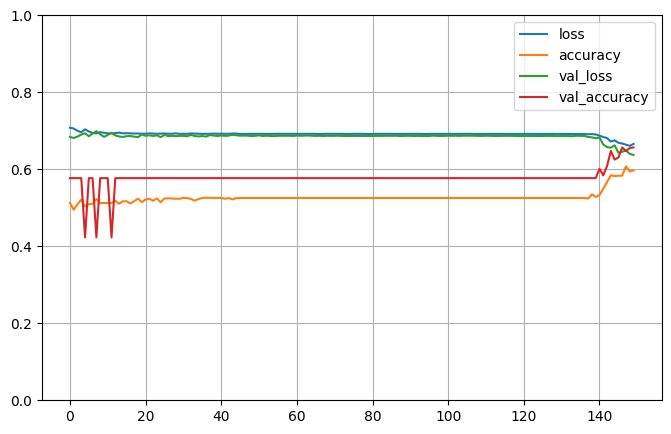


Testing # 1 1
2023-04-09 13:41:15.523153
2023-04-09 13:41:15.523209
PREDICT
2023-04-09 13:41:15.536464
Test 1:0 228:311 42.30%
Predict 1:0 165:374 30.61%
Test sizes (539, 1025) (539,)
Distrib of scores: 0.45311472 mean 0.09955841 std
Range of scores: 0.16712944 to 0.71916485
Score threshold 0.5
Confusion matrix
 [[250  61]
 [124 104]]
Normalized matrix
 [[0.46382189 0.11317254]
 [0.23005566 0.19294991]]
Extreme scores correct, pos:neg 11 63
Extreme scores incorrect pos:neg 5 13


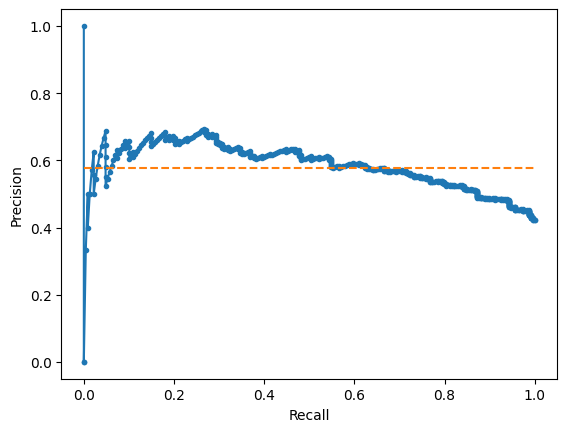

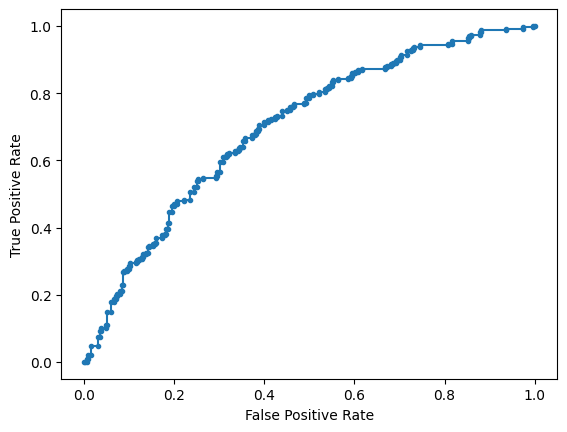

Accuracy: 65.68% Precision: 63.03% Recall: 45.61%
F1: 52.93% MCC: 0.2787
AUPRC: 58.33% AUROC: 69.84%
 accuracy [65.67717996289424]
 precision [63.030303030303024]
 recall [45.614035087719294]
 F1 [52.926208651399484]
 MCC [0.27870278481503685]
 AUPRC [58.32963491594177]
 AUROC [69.83838212895583]

Training # 1 2
2023-04-09 13:41:16.159495
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.validation_genes.txt
2023-04-09 13:41:16.527814
Discriminator ZERO -1
Train 1:0 1643:1853 47.00%
Valid 1:0 241:305 44.14%
FIT
2023-04-09 13:41:16.619084


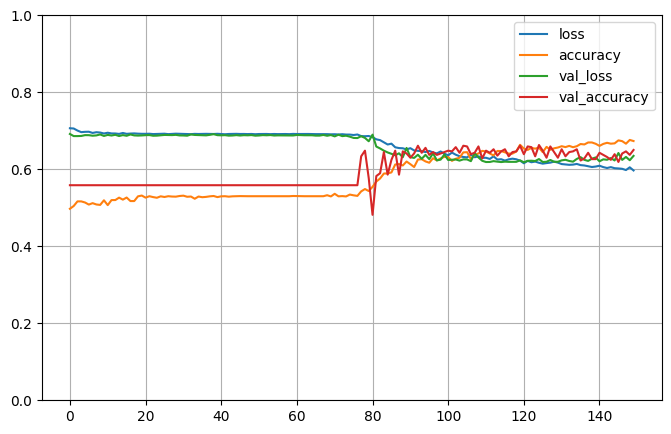


Testing # 1 2
2023-04-09 13:42:52.591783
2023-04-09 13:42:52.591830
PREDICT
2023-04-09 13:42:52.600066
Test 1:0 241:305 44.14%
Predict 1:0 316:230 57.88%
Test sizes (546, 1025) (546,)
Distrib of scores: 0.51532495 mean 0.18949986 std
Range of scores: 0.006672691 to 0.8557411
Score threshold 0.5
Confusion matrix
 [[172 133]
 [ 58 183]]
Normalized matrix
 [[0.31501832 0.24358974]
 [0.10622711 0.33516484]]
Extreme scores correct, pos:neg 88 92
Extreme scores incorrect pos:neg 57 16


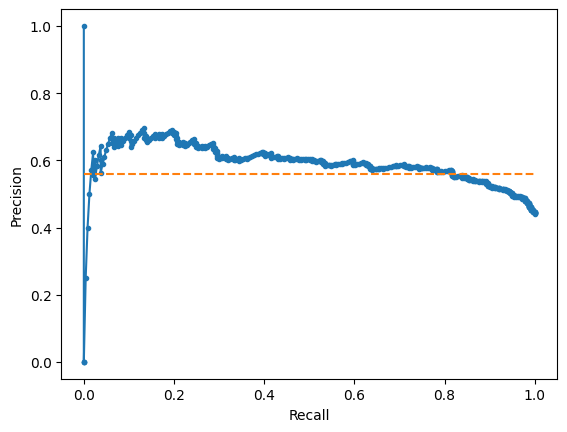

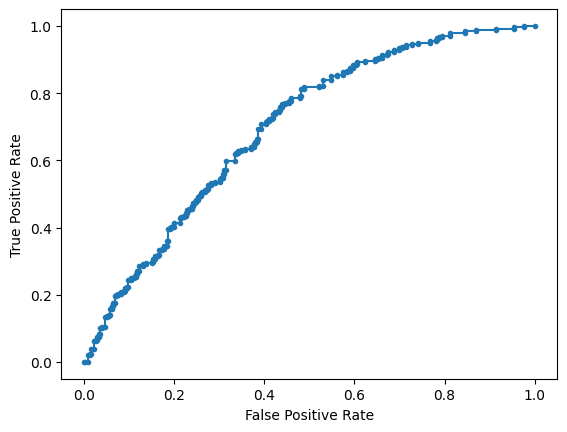

Accuracy: 65.02% Precision: 57.91% Recall: 75.93%
F1: 65.71% MCC: 0.3251
AUPRC: 59.19% AUROC: 69.80%
 accuracy [65.01831501831502]
 precision [57.91139240506329]
 recall [75.93360995850622]
 F1 [65.70915619389586]
 MCC [0.3251000911536389]
 AUPRC [59.19358849392753]
 AUROC [69.79525202367188]

Training # 1 3
2023-04-09 13:42:53.439342
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.validation_genes.txt
2023-04-09 13:42:53.740687
Discriminator ZERO -1
Train 1:0 1671:1826 47.78%
Valid 1:0 216:303 41.62%
FIT
2023-04-09 13:42:53.831891


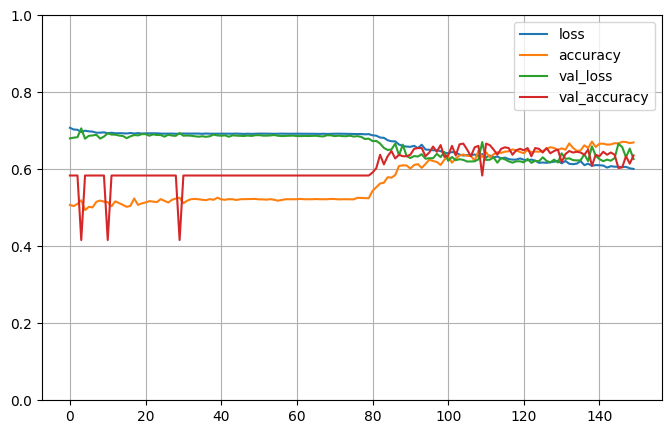


Testing # 1 3
2023-04-09 13:44:29.024076
2023-04-09 13:44:29.024121
PREDICT
2023-04-09 13:44:29.028930
Test 1:0 216:303 41.62%
Predict 1:0 225:294 43.35%
Test sizes (519, 1025) (519,)
Distrib of scores: 0.44135332 mean 0.19184446 std
Range of scores: 0.011516587 to 0.81752115
Score threshold 0.5
Confusion matrix
 [[204  99]
 [ 90 126]]
Normalized matrix
 [[0.39306358 0.19075145]
 [0.1734104  0.24277457]]
Extreme scores correct, pos:neg 55 137
Extreme scores incorrect pos:neg 38 38


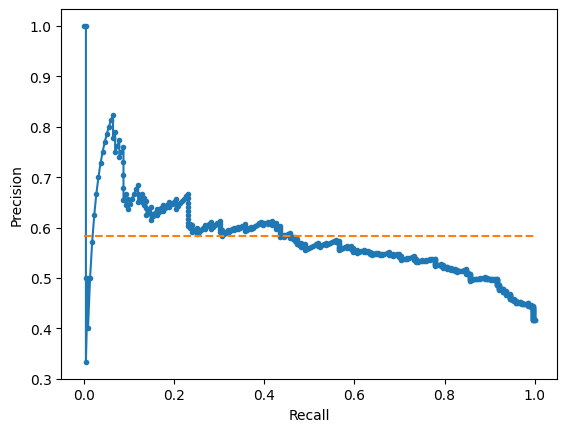

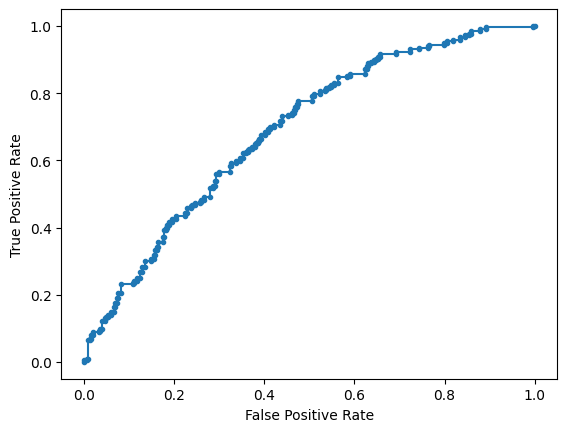

Accuracy: 63.58% Precision: 56.00% Recall: 58.33%
F1: 57.14% MCC: 0.2552
AUPRC: 57.71% AUROC: 68.92%
 accuracy [63.58381502890174]
 precision [56.00000000000001]
 recall [58.333333333333336]
 F1 [57.14285714285714]
 MCC [0.25523547396037644]
 AUPRC [57.70963785944976]
 AUROC [68.91578046693557]

Training # 1 4
2023-04-09 13:44:29.652088
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.validation_genes.txt
2023-04-09 13:44:29.957380
Discriminator ZERO -1
Train 1:0 1637:1860 46.81%
Valid 1:0 231:284 44.85%
FIT
2023-04-09 13:44:30.045085


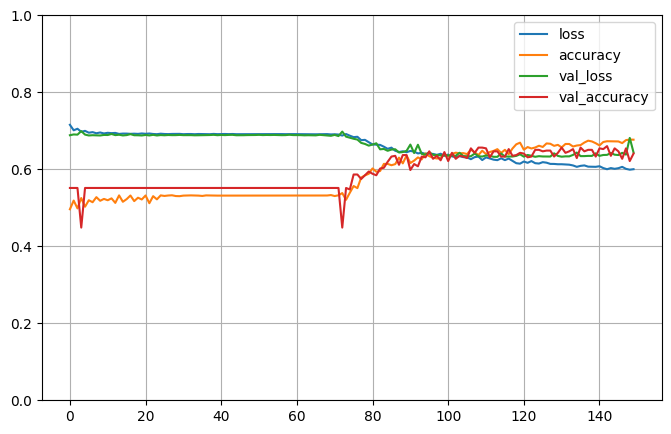


Testing # 1 4
2023-04-09 13:46:53.317351
2023-04-09 13:46:53.317439
PREDICT
2023-04-09 13:46:53.331913
Test 1:0 231:284 44.85%
Predict 1:0 270:245 52.43%
Test sizes (515, 1025) (515,)
Distrib of scores: 0.498394 mean 0.19726755 std
Range of scores: 0.016764138 to 0.85183036
Score threshold 0.5
Confusion matrix
 [[172 112]
 [ 73 158]]
Normalized matrix
 [[0.33398058 0.21747573]
 [0.14174757 0.30679612]]
Extreme scores correct, pos:neg 84 93
Extreme scores incorrect pos:neg 48 23


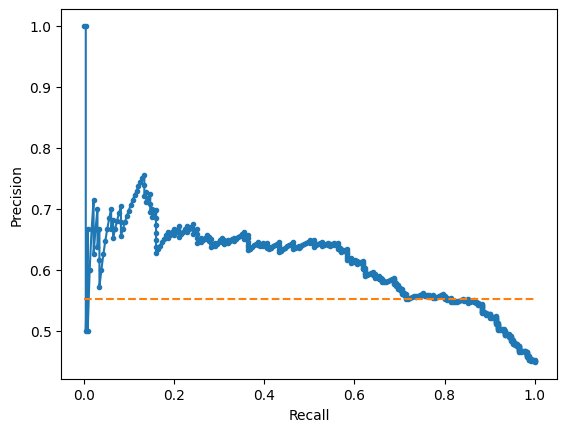

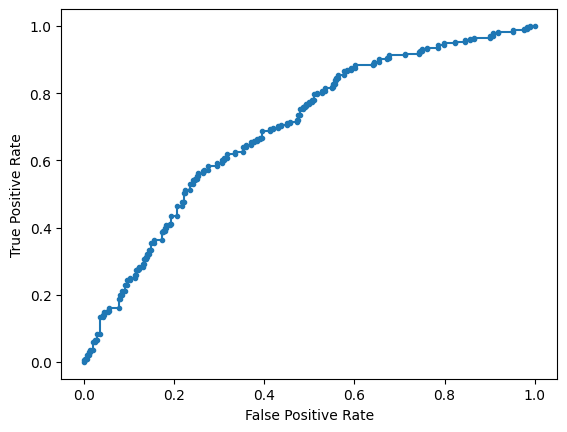

Accuracy: 64.08% Precision: 58.52% Recall: 68.40%
F1: 63.07% MCC: 0.2884
AUPRC: 61.17% AUROC: 69.40%
 accuracy [64.07766990291263]
 precision [58.51851851851851]
 recall [68.3982683982684]
 F1 [63.07385229540918]
 MCC [0.2884187675504414]
 AUPRC [61.16544083585354]
 AUROC [69.40278031827329]

Training # 1 5
2023-04-09 13:46:54.396108
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.validation_genes.txt
2023-04-09 13:46:54.764305
Discriminator ZERO -1
Train 1:0 1634:1864 46.71%
Valid 1:0 251:283 47.00%
FIT
2023-04-09 13:46:54.920058


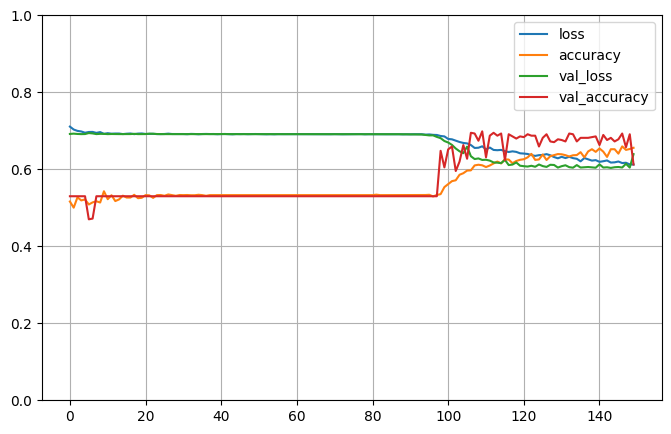


Testing # 1 5
2023-04-09 13:48:29.637969
2023-04-09 13:48:29.638022
PREDICT
2023-04-09 13:48:29.644577
Test 1:0 251:283 47.00%
Predict 1:0 402:132 75.28%
Test sizes (534, 1025) (534,)
Distrib of scores: 0.5746219 mean 0.14289996 std
Range of scores: 0.09974775 to 0.8028171
Score threshold 0.5
Confusion matrix
 [[104 179]
 [ 28 223]]
Normalized matrix
 [[0.19475655 0.33520599]
 [0.05243446 0.417603  ]]
Extreme scores correct, pos:neg 130 40
Extreme scores incorrect pos:neg 52 4


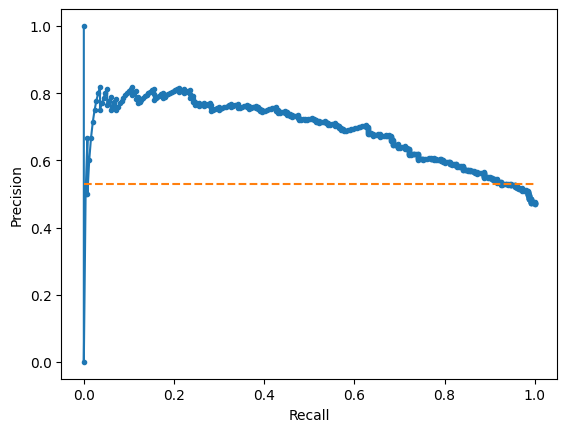

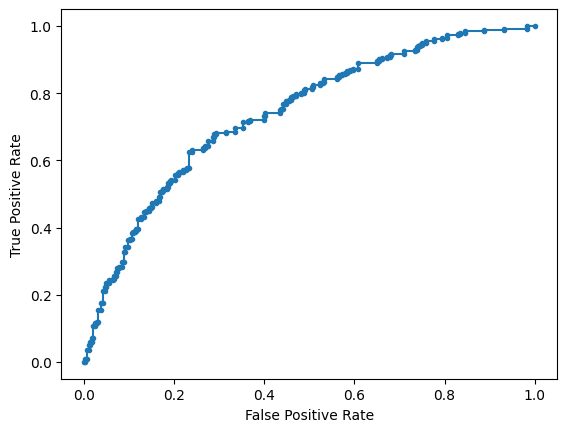

Accuracy: 61.24% Precision: 55.47% Recall: 88.84%
F1: 68.30% MCC: 0.2961
AUPRC: 68.92% AUROC: 74.01%
 accuracy [61.23595505617978]
 precision [55.472636815920396]
 recall [88.84462151394422]
 F1 [68.30015313935681]
 MCC [0.296117318689514]
 AUPRC [68.91662117137165]
 AUROC [74.01207889290895]

Training # 2 1
2023-04-09 13:48:30.241447
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.validation_genes.txt
2023-04-09 13:48:30.486383
Discriminator ZERO -1
Train 1:0 1655:1841 47.34%
Valid 1:0 226:299 43.05%
FIT
2023-04-09 13:48:30.583878


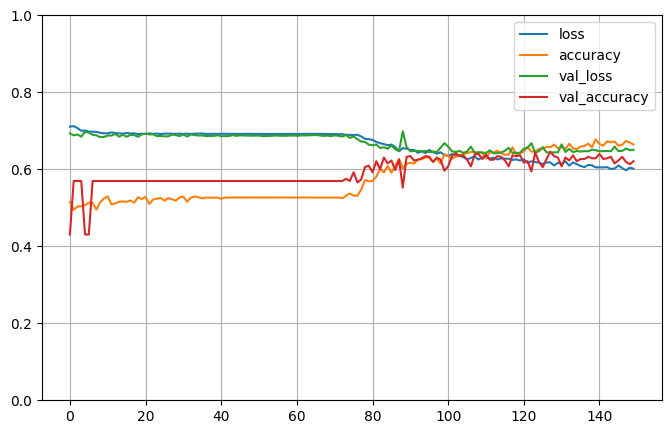


Testing # 2 1
2023-04-09 13:50:53.860701
2023-04-09 13:50:53.860758
PREDICT
2023-04-09 13:50:53.871123
Test 1:0 226:299 43.05%
Predict 1:0 197:328 37.52%
Test sizes (525, 1025) (525,)
Distrib of scores: 0.4237964 mean 0.19561797 std
Range of scores: 0.0025480667 to 0.83728665
Score threshold 0.5
Confusion matrix
 [[214  85]
 [114 112]]
Normalized matrix
 [[0.40761905 0.16190476]
 [0.21714286 0.21333333]]
Extreme scores correct, pos:neg 45 141
Extreme scores incorrect pos:neg 27 49


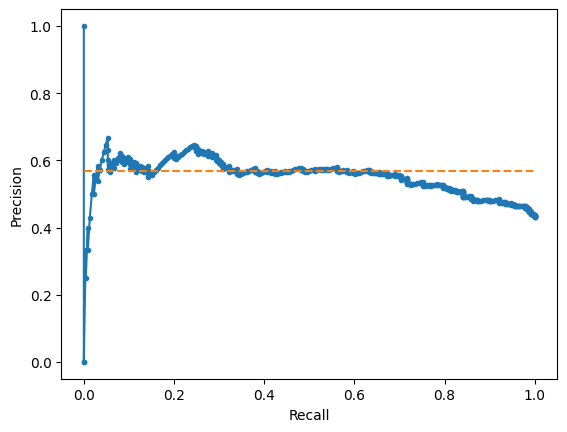

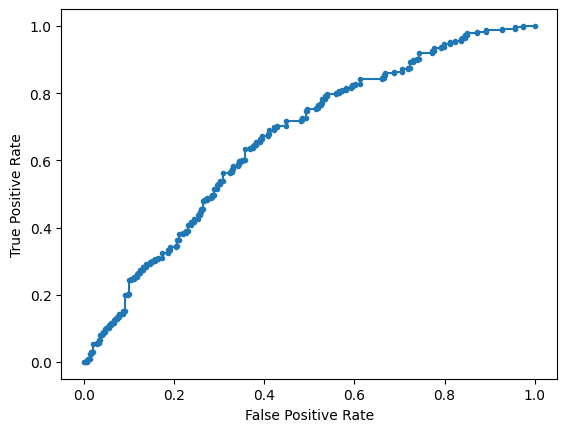

Accuracy: 62.10% Precision: 56.85% Recall: 49.56%
F1: 52.96% MCC: 0.2161
AUPRC: 55.15% AUROC: 66.42%
 accuracy [62.095238095238095]
 precision [56.852791878172596]
 recall [49.557522123893804]
 F1 [52.9550827423168]
 MCC [0.21607649621938918]
 AUPRC [55.15320344061514]
 AUROC [66.4205167668038]

Training # 2 2
2023-04-09 13:50:54.459056
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.validation_genes.txt
2023-04-09 13:50:54.709083
Discriminator ZERO -1
Train 1:0 1645:1851 47.05%
Valid 1:0 238:297 44.49%
FIT
2023-04-09 13:50:54.796906


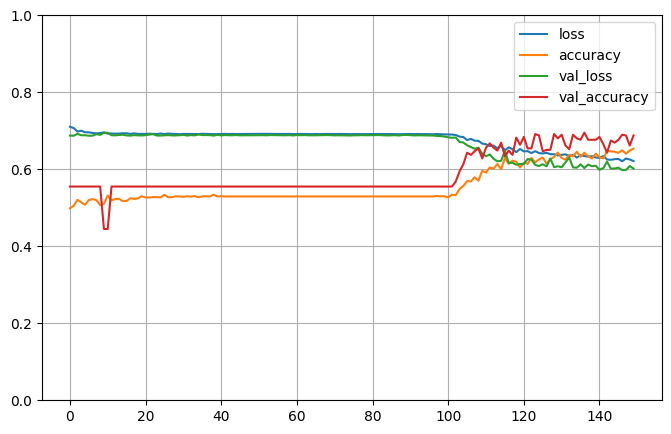


Testing # 2 2
2023-04-09 13:53:18.217892
2023-04-09 13:53:18.218327
PREDICT
2023-04-09 13:53:18.225207
Test 1:0 238:297 44.49%
Predict 1:0 261:274 48.79%
Test sizes (535, 1025) (535,)
Distrib of scores: 0.4740962 mean 0.17278235 std
Range of scores: 0.030769037 to 0.78423774
Score threshold 0.5
Confusion matrix
 [[202  95]
 [ 72 166]]
Normalized matrix
 [[0.37757009 0.17757009]
 [0.13457944 0.31028037]]
Extreme scores correct, pos:neg 72 109
Extreme scores incorrect pos:neg 28 19


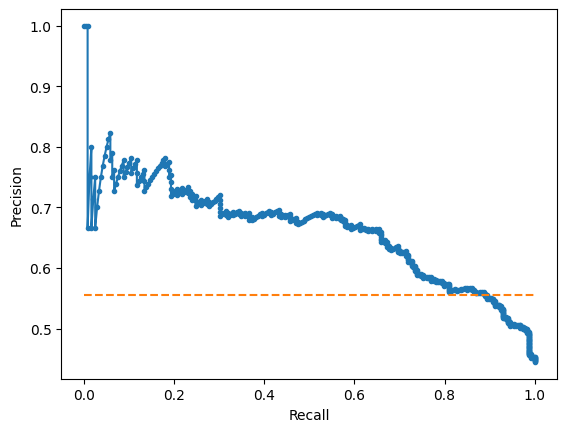

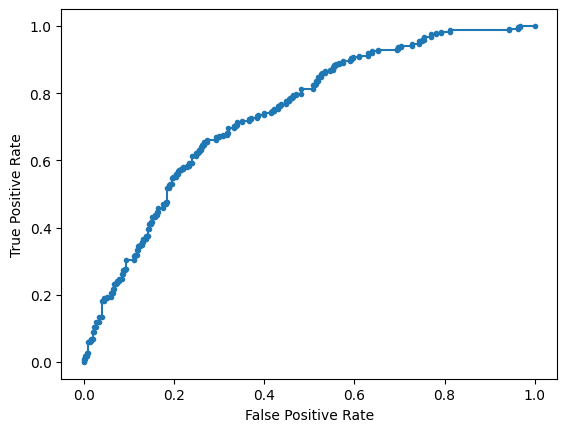

Accuracy: 68.79% Precision: 63.60% Recall: 69.75%
F1: 66.53% MCC: 0.3754
AUPRC: 66.24% AUROC: 74.12%
 accuracy [68.78504672897196]
 precision [63.601532567049816]
 recall [69.74789915966386]
 F1 [66.53306613226452]
 MCC [0.37542127292930577]
 AUPRC [66.24372510628731]
 AUROC [74.12358882947116]

Training # 2 3
2023-04-09 13:53:19.192169
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.validation_genes.txt
2023-04-09 13:53:19.541174
Discriminator ZERO -1
Train 1:0 1634:1863 46.73%
Valid 1:0 243:288 45.76%
FIT
2023-04-09 13:53:19.672528


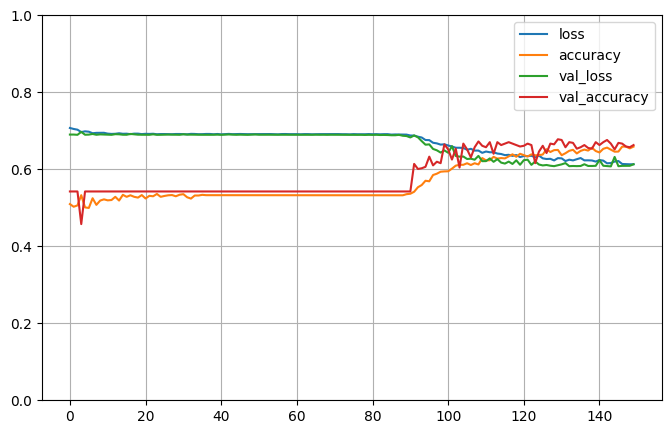


Testing # 2 3
2023-04-09 13:55:44.162064
2023-04-09 13:55:44.162113
PREDICT
2023-04-09 13:55:44.172192
Test 1:0 243:288 45.76%
Predict 1:0 298:233 56.12%
Test sizes (531, 1025) (531,)
Distrib of scores: 0.49794567 mean 0.17377026 std
Range of scores: 0.03299518 to 0.76914537
Score threshold 0.5
Confusion matrix
 [[171 117]
 [ 62 181]]
Normalized matrix
 [[0.3220339  0.22033898]
 [0.11676083 0.34086629]]
Extreme scores correct, pos:neg 70 97
Extreme scores incorrect pos:neg 40 11


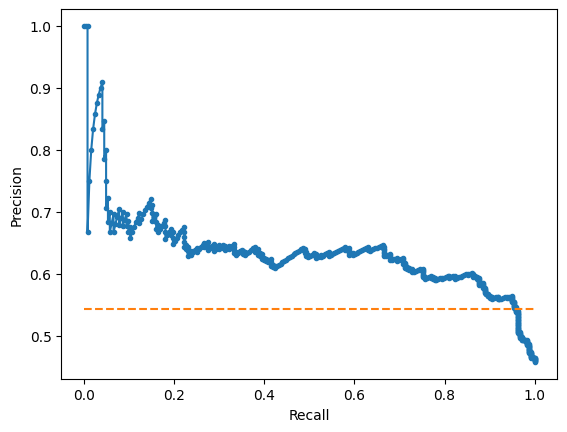

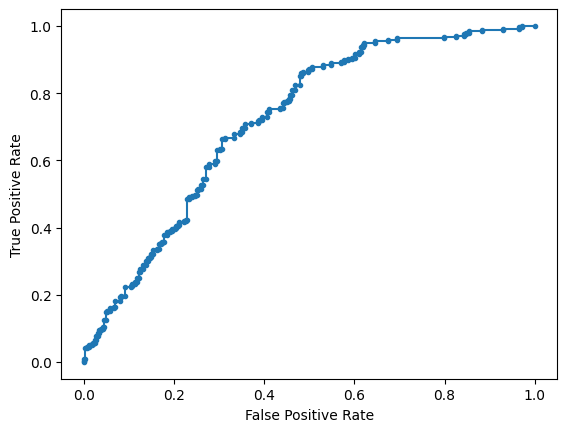

Accuracy: 66.29% Precision: 60.74% Recall: 74.49%
F1: 66.91% MCC: 0.3399
AUPRC: 63.57% AUROC: 71.94%
 accuracy [66.29001883239172]
 precision [60.738255033557046]
 recall [74.48559670781893]
 F1 [66.91312384473198]
 MCC [0.3399444031325251]
 AUPRC [63.56979405405462]
 AUROC [71.94358710562415]

Training # 2 4
2023-04-09 13:55:44.821859
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.validation_genes.txt
2023-04-09 13:55:45.050952
Discriminator ZERO -1
Train 1:0 1669:1829 47.71%
Valid 1:0 214:313 40.61%
FIT
2023-04-09 13:55:45.138825


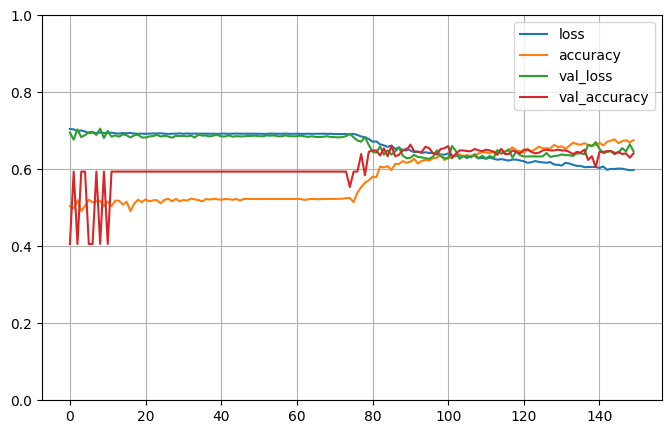


Testing # 2 4
2023-04-09 13:57:21.632644
2023-04-09 13:57:21.632695
PREDICT
2023-04-09 13:57:21.641450
Test 1:0 214:313 40.61%
Predict 1:0 201:326 38.14%
Test sizes (527, 1025) (527,)
Distrib of scores: 0.4341395 mean 0.2100382 std
Range of scores: 0.027790785 to 0.86919063
Score threshold 0.5
Confusion matrix
 [[225  88]
 [101 113]]
Normalized matrix
 [[0.42694497 0.16698292]
 [0.19165085 0.21442125]]
Extreme scores correct, pos:neg 58 146
Extreme scores incorrect pos:neg 45 49


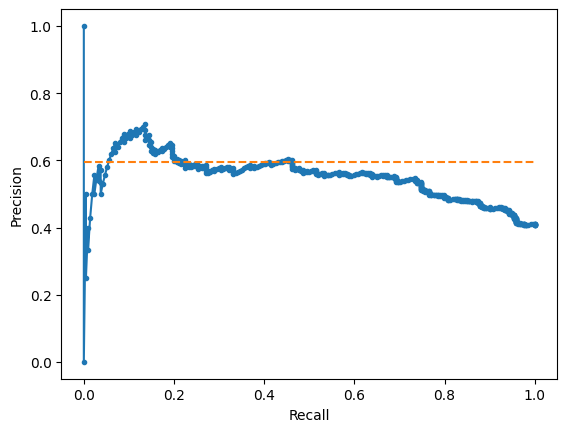

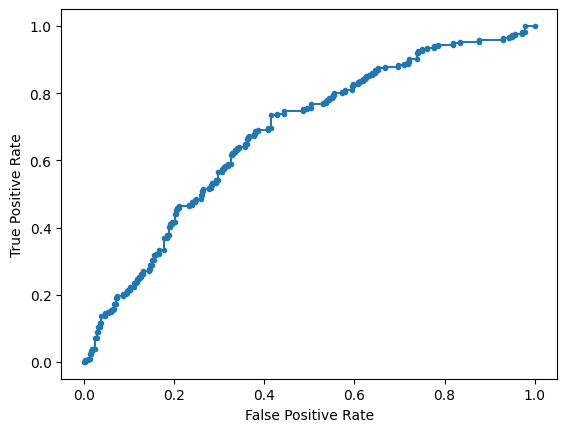

Accuracy: 64.14% Precision: 56.22% Recall: 52.80%
F1: 54.46% MCC: 0.2496
AUPRC: 55.02% AUROC: 67.84%
 accuracy [64.13662239089184]
 precision [56.21890547263681]
 recall [52.80373831775701]
 F1 [54.4578313253012]
 MCC [0.24961509342966942]
 AUPRC [55.01659201596585]
 AUROC [67.84061389627064]

Training # 2 5
2023-04-09 13:57:22.294929
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.validation_genes.txt
2023-04-09 13:57:22.525676
Discriminator ZERO -1
Train 1:0 1641:1856 46.93%
Valid 1:0 246:289 45.98%
FIT
2023-04-09 13:57:22.616894


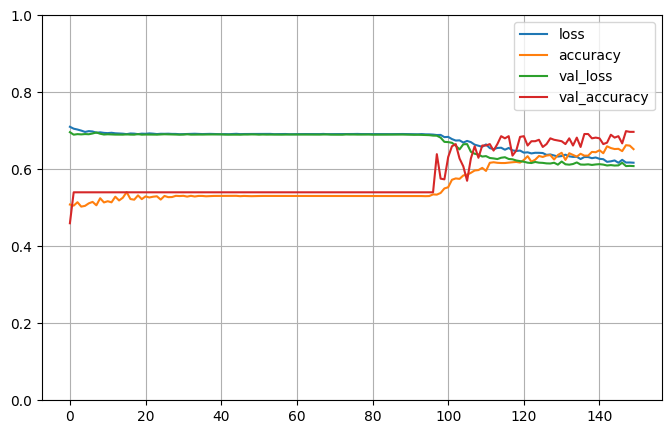


Testing # 2 5
2023-04-09 13:59:45.933773
2023-04-09 13:59:45.933836
PREDICT
2023-04-09 13:59:45.941553
Test 1:0 246:289 45.98%
Predict 1:0 222:313 41.50%
Test sizes (535, 1025) (535,)
Distrib of scores: 0.45520374 mean 0.17223854 std
Range of scores: 0.022034237 to 0.7906012
Score threshold 0.5
Confusion matrix
 [[220  69]
 [ 93 153]]
Normalized matrix
 [[0.41121495 0.12897196]
 [0.17383178 0.28598131]]
Extreme scores correct, pos:neg 58 124
Extreme scores incorrect pos:neg 23 31


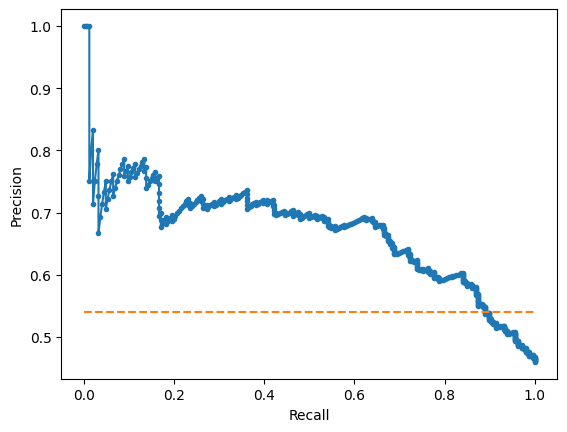

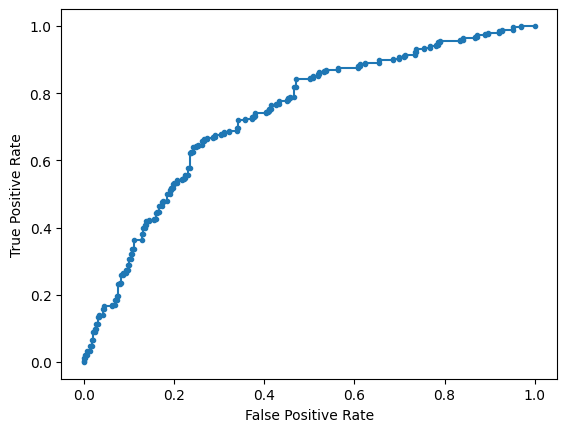

Accuracy: 69.72% Precision: 68.92% Recall: 62.20%
F1: 65.38% MCC: 0.3876
AUPRC: 67.01% AUROC: 73.37%
 accuracy [69.71962616822431]
 precision [68.91891891891892]
 recall [62.19512195121951]
 F1 [65.38461538461539]
 MCC [0.38760538267533867]
 AUPRC [67.00638640132597]
 AUROC [73.37046726868654]
2023-04-09 13:59:46.536634


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
            if SAVE_MODEL_FILENAME is not None:
                filename = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                cvdo.save_model(filename)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                None,None,None)

        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 65.06% std 2.69
 precision mean 59.73% std 4.33
 recall mean 64.59% std 13.44
 F1 mean 61.34% std 6.25
 MCC mean 0.3012 std 0.0555
 AUPRC mean 61.23% std 4.98
 AUROC mean 70.57% std 2.67
 accuracy [[65.67717996289424], [65.01831501831502], [63.58381502890174], [64.07766990291263], [61.23595505617978], [62.095238095238095], [68.78504672897196], [66.29001883239172], [64.13662239089184], [69.71962616822431]]
 precision [[63.030303030303024], [57.91139240506329], [56.00000000000001], [58.51851851851851], [55.472636815920396], [56.852791878172596], [63.601532567049816], [60.738255033557046], [56.21890547263681], [68.91891891891892]]
 recall [[45.614035087719294], [75.93360995850622], [58.333333333333336], [68.3982683982684], [88.84462151394422], [49.557522123893804], [69.74789915966386], [74.48559670781893], [52.80373831775701], [62.19512195121951]]
 F1 [[52.926208651399484], [65.70915619389586], [57.14285714285714], [63.07385229540918], [68.30015313935681], [52.9550827423168